# Setup

In [1]:
path = "data/join"
topic = "立法方式保障"

In [2]:
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import jieba
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, Conv1D, ZeroPadding1D, MaxPooling1D
from sklearn.manifold import TSNE
import os, math, re, pickle

jieba.set_dictionary(os.path.join("data", "dict.txt.big"))
zh_font = matplotlib.font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc", size=16)

Using TensorFlow backend.


In [3]:
_data = None

def load_data():
    global _data
    if _data is None:
        _data = pd.read_csv(os.path.join(path, topic + "-sentences.csv"))
    return _data

Build dictionary for word embedding.

In [4]:
dictionary_path = os.path.join(path, "dictionary.pkl")

clean_phrase_re = re.compile(r"[ ]+")

def cleaned_phrase(phrases):
    for ph in phrases:
        ph = clean_phrase_re.sub("", ph)
        if ph != "":
            yield ph

def create_dictionary(*data):
    phrases = {}
    for d in data:
        for sentence in d:
            for ph in cleaned_phrase(jieba.cut(str(sentence))):
                phrases[ph] = True
    with open(os.path.join(path, "dictionary.txt"), "w") as fh:
        fh.writelines([ ph + "\n" for ph in phrases.keys() ])
    !cd $path; mkdir -p models; ln ../fasttext/wiki.zh.bin models/wiki.zh.bin
    !cd $path; ~/bin/fasttext print-word-vectors models/wiki.zh.bin < dictionary.txt > dictionary.vec
    dictionary = pd.read_csv(os.path.join(path, "dictionary.vec"), 
                             delim_whitespace=True, engine="python", header=None, index_col=0)
    with open(dictionary_path, "wb") as fh:
        pickle.dump([{ ph: i for i, ph in enumerate(dictionary.index) }, dictionary], fh)

def load_dictionary():
    with open(dictionary_path, "rb") as fh:
        [ dict_index, dictionary ] = pickle.load(fh)
        return dict_index, dictionary
    
if not os.path.exists(dictionary_path):
    data = load_data()
    create_dictionary(data.sentence)

dict_index, dictionary = load_dictionary()
phrases_n = len(dictionary)
latent_n = len(dictionary.columns)

In [5]:
dict_tsne = TSNE(n_components=2).fit_transform(dictionary.values[:1000])

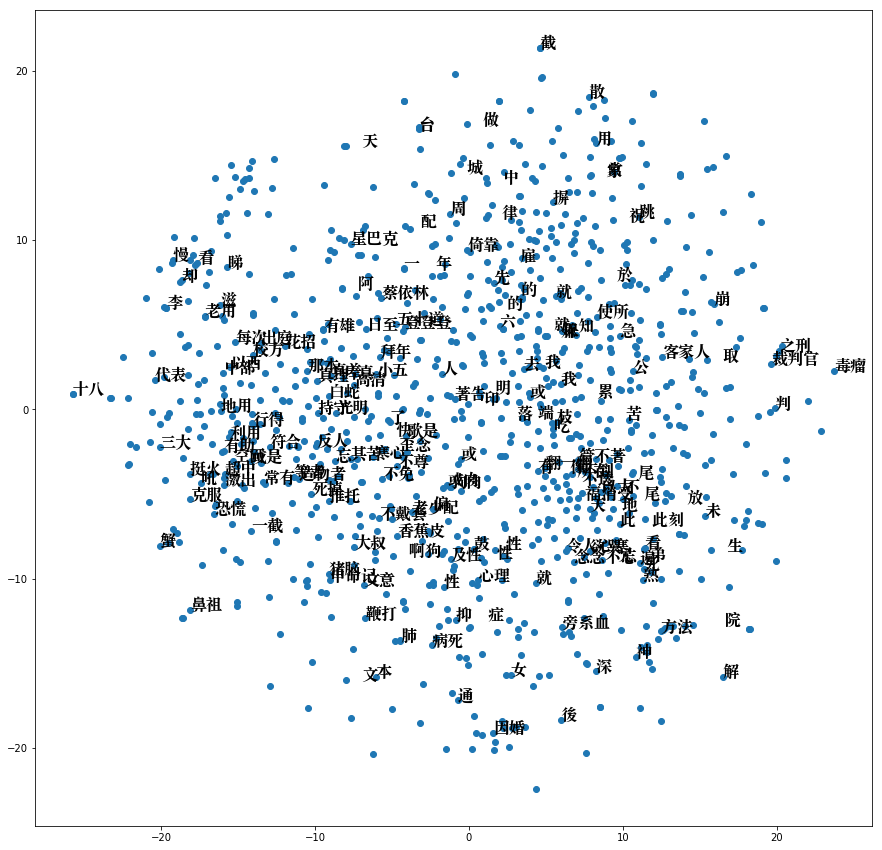

In [7]:
tsne_start = 0
tsne_end = 200
plt.figure(figsize=(15, 15))
plt.scatter(dict_tsne[:, 0], dict_tsne[:, 1])
for label, x, y in zip(dictionary.index[tsne_start:tsne_end], dict_tsne[:, 0], dict_tsne[:, 1]):
    plt.text(x, y, label, fontproperties=zh_font)
plt.savefig("dict_viz.png")

Examine phrase length.

In [5]:
#data = load_data()
#stat = np.frompyfunc(lambda s: len(jieba.lcut(str(s))), 1, 1)(data.sentence.values)
#(stat.min(), stat.max(), stat.mean(), stat.std())

Encode lables and embed phrases.

In [6]:
# phrase-length (min, max, mean, std) = (1, 1096, 17.385437090122373, 20.549680891647231)
input_length = 20

data_path = os.path.join(path, "data.pkl")

orid_index = { "O": 0, "R": 1, "I": 2, "D": 3 }

def get_label(df):
    labels = np.zeros((len(df), 4))
    for i, l in enumerate(df["orid"]):
        j = orid_index[l]
        labels[i, j] = 1
    return labels

def get_text(df):
    texts = np.zeros((len(df), input_length))
    for i, text in enumerate(df["sentence"].values):
        for j, ph in enumerate(cleaned_phrase(jieba.lcut(str(text)))):
            if j >= input_length:
                break
            if ph in dict_index:
                texts[i, j] = dict_index[ph]
    return texts

if not os.path.exists(data_path):
    data = load_data()
    data = data[data["orid"].notnull()]
    mask = np.random.random(len(data)) > 0.1
    train, valid = data[mask], data[~mask]
    train_x, train_y = get_text(train), get_label(train)
    valid_x, valid_y = get_text(valid), get_label(valid)
    
    with open(data_path, "wb") as fh:
        pickle.dump([(train_x, train_y), (valid_x, valid_y)], fh)
else:
    with open(data_path, "rb") as fh:
        [(train_x, train_y), (valid_x, valid_y)] = pickle.load(fh)

# Simple CNN

In [53]:
batch_size = 64

def simple_cnn_model():
    model = Sequential()
    model.add(Embedding(phrases_n, latent_n, input_length=input_length, weights=[dictionary], trainable=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv1D(64, 3, border_mode="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.7))
    model.add(Dense(4, activation="sigmoid"))
    return model
    
simple_cnn = simple_cnn_model()
simple_cnn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])
simple_cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_11 (Embedding)         (None, 20, 300)       9825000     embedding_input_11[0][0]         
____________________________________________________________________________________________________
batchnormalization_21 (BatchNorm (None, 20, 300)       1200        embedding_11[0][0]               
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 20, 300)       0           batchnormalization_21[0][0]      
____________________________________________________________________________________________________
convolution1d_11 (Convolution1D) (None, 20, 64)        57664       dropout_31[0][0]                 
___________________________________________________________________________________________

In [54]:
def train_simple_cnn(lr=None, epoch=1, full=False):
    if lr is not None:
        simple_cnn.optimizer.lr = lr
    if full:
        simple_cnn.layers[0].trainable = True
    simple_cnn.fit(train_x, train_y, nb_epoch=epoch, batch_size=batch_size, validation_data=(valid_x, valid_y))
    
train_simple_cnn(1e-4)
train_simple_cnn(1e-1, 4)
train_simple_cnn(1e-2, 8)
train_simple_cnn(1e-3, 8)
train_simple_cnn(1e-4, 2, full=True)

Train on 175 samples, validate on 23 samples
Epoch 1/1
175/175 [==============================] - 0s - loss: 2.1160 - acc: 0.2857 - val_loss: 1.3771 - val_acc: 0.4783
Train on 175 samples, validate on 23 samples
Epoch 1/4
175/175 [==============================] - 0s - loss: 1.6770 - acc: 0.3086 - val_loss: 1.3731 - val_acc: 0.5652
Epoch 2/4
175/175 [==============================] - 0s - loss: 1.8868 - acc: 0.3257 - val_loss: 1.3697 - val_acc: 0.5652
Epoch 3/4
175/175 [==============================] - 0s - loss: 1.6635 - acc: 0.3486 - val_loss: 1.3666 - val_acc: 0.5652
Epoch 4/4
175/175 [==============================] - 0s - loss: 1.5803 - acc: 0.3371 - val_loss: 1.3641 - val_acc: 0.5652
Train on 175 samples, validate on 23 samples
Epoch 1/8
175/175 [==============================] - 0s - loss: 1.4688 - acc: 0.3771 - val_loss: 1.3623 - val_acc: 0.5652
Epoch 2/8
175/175 [==============================] - 0s - loss: 1.3744 - acc: 0.4000 - val_loss: 1.3609 - val_acc: 0.5652
Epoch 3/8
1

In [55]:
simple_cnn.save_weights(os.path.join(path, "models", "simple_cnn.h5"))

# Evaluate model

In [56]:
model = simple_cnn_model()
model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.load_weights(os.path.join(path, "models", "simple_cnn.h5"))

In [57]:
testing_path = os.path.join(path, "testing.pkl")

_testing = None

def load_testing():
    if not os.path.exists(testing_path):
        data = load_data()
        data = data[data["orid"].isnull()]
        _testing = get_text(data)
        with open(testing_path, "wb") as fh:
            pickle.dump(_testing, fh)
        return _testing
    else:
        with open(testing_path, "rb") as fh:
            return pickle.load(fh)

data = load_data()
data = data[data["orid"].isnull()]
testing = load_testing()
pred = model.predict(testing, batch_size=batch_size)

In [58]:
pred

array([[ 0.43110189,  0.5061273 ,  0.57010287,  0.49707159],
       [ 0.46737763,  0.52265048,  0.56997561,  0.51680809],
       [ 0.46599391,  0.48684579,  0.53707284,  0.5031637 ],
       ..., 
       [ 0.50346696,  0.48446396,  0.53563052,  0.50433385],
       [ 0.46854225,  0.50290263,  0.5925886 ,  0.49854097],
       [ 0.47502753,  0.47676295,  0.53359419,  0.46701998]], dtype=float32)

## Objective

In [59]:
data[pred[:, 0] > 0.6].sentence

3237     而婚姻的與時俱進包含: 1 禁止同<姓>結婚 理由為防止近親性交  2 過去夫權獨大 3 所...
28082    而婚姻的與時俱進包含: 1 禁止同<姓>結婚 理由為防止近親性交  2 過去夫權獨大 3 所...
36836    然而婚姻的與時俱進包含: 1 禁止同<姓>結婚 理由為防止近親性交  2 過去夫權獨大 3 ...
Name: sentence, dtype: object

## Reflective

In [60]:
data[pred[:, 1] > 0.6].sentence

9770               <  是怎麼製造的，同志本來就不會和異性結婚，那到底你說的單親家庭是從哪裡來的
15429     : 台灣誤家盟 < 誤家盟 > :  ,    ,      : 法務部同性婚姻民調，請大...
22897                                               <-你的邏輯
24268                              正在爭啊 保障同性戀者的權益 << 目前並沒有
25755                                 <用平等的心,把每一個人擁入憲法的懷抱>
34251    <補充>因為我國尚未承認同性婚姻,經過國際人權專家提出建議和指正應該積極更正社會歧視問題 如...
41252                    請尊重不同聲音言論自由 年 月 日 上午 於     < >寫道：
42010                                                    <
Name: sentence, dtype: object

## Interpretive

In [61]:
data[pred[:, 2] > 0.6].sentence

43                          >什麼是成熟 與 不成熟的 感情觀 輕描淡寫>甚至不要教更好
123      我解釋一下好了, 免得亂掉 > <在一般的異性戀生殖中, 若有一方因疾病或是其他因素而導致不...
908                                     輿論害死多少家庭，中國人直是禮教吃人
969                                    不是炮反對票，是炮那些腦子已經腐化的人
1420                                    大人們也應該如此做啊，才是以身作則吧
1774                              為什麼 討厭同性戀 三個字不能 大纍纍的說出來呢
2309                                   根據法務部過去的做法，這是很有可能的事
2362                 必竟不是自己骨肉<那異性戀領養的也是有性侵案例啊,你到底要出來反領養了沒啊
2826                                   只能拿來騙騙3歲小孩和無知的熱血青年喔
3237     而婚姻的與時俱進包含: 1 禁止同<姓>結婚 理由為防止近親性交  2 過去夫權獨大 3 所...
3598                                   只能拿來騙騙3歲小孩和無知的熱血青年喔
3647                                      上帝是愛 是不是跟你想的差更多了
3729                                      回覆:不爽同性戀那請問您來做甚麼
3842                                             變裝慾->哪裡不好
4752                                   我沒擔心古人，以色列人，你又胡說八道了
5040                                   只能拿來騙騙3歲小孩和無知的熱血青年喔
5264                                    這一點沒錯同性戀去病化 是在 年

## Decision

In [62]:
data[pred[:, 3] > 0.6].sentence

123      我解釋一下好了, 免得亂掉 > <在一般的異性戀生殖中, 若有一方因疾病或是其他因素而導致不...
5869                                      別理這些王雪紅了、浪費時間 <3
11053                                      下午 於     < >寫道：
15244     也就是說你根本反收養吧不然有這種異性戀傾向 又領養到不是親生骨肉的 <領養就不會是親生的啦...
15429     : 台灣誤家盟 < 誤家盟 > :  ,    ,      : 法務部同性婚姻民調，請大...
19427                                    >>>正在積極面對卻一直被窮追猛打
22089                                      下午 於     < >寫道：
23505    祝福大家都有情人終成眷屬： 單身也幸福唷    >w<  不論結果如何，願過往的傷痛隨風而去...
24354                                    上午  於     < > 寫道：
31640                                              我快笑死> <
33136                          上帝愛你們 年 月 日 下午 於     < >寫道：
42367           >現代婚姻會有這麼多問題>不是因為異性戀 或 同性戀的問題>而是情慾流動 卻不知節制
43294                                年 月 日 下午 於     < >寫道：
Name: sentence, dtype: object